# Solution Space Visualization

This notebook contains an example of how we can use the torch backend to retrieve the gradients of a simple RMS loss function with respect to the variables R1 and R2, the radii of the singlet lens. Note that although the same analysis could be performed with usual ray tracing procedures and then finite differences to compute the derivates, we illustrate here how to quickly get the necessary gradients within the automatic differentiation framework PyTorch.

In [1]:
import optiland.backend as be
from optiland.optic import Optic
from optiland.materials import IdealMaterial
from optiland.rays import RealRays
from optiland.analysis import SpotDiagram
import torch
import matplotlib.pyplot as plt

In [ ]:
class Lens(Optic):
    def __init__(self):
        super().__init__()

        self.add_surface(index=0, thickness=be.inf)
        self.add_surface(
            index=1,
            radius=30,
            surface_type="standard",
            is_stop=True,
            thickness=4.0,
            material=IdealMaterial(n=1.5, k=0),
        )
        self.add_surface(index=2, thickness=35.0, material="air")
        self.add_surface(index=3)

        self.set_aperture(aperture_type="EPD", value=20.0)
        self.add_wavelength(value=0.550, is_primary=True)
        self.set_field_type("angle")
        self.add_field(y=0)

In [3]:
be.set_backend("torch")
be.set_device(
    "cpu"
)  # we will stick to cpu for now. "cuda" is also possible for GPU calculations.
print(be.get_precision())  # check the precision

# enable the gradient mode: to tell autograd to begin recording operations on a Tensor tensor
be.grad_mode.enable()

torch.float32


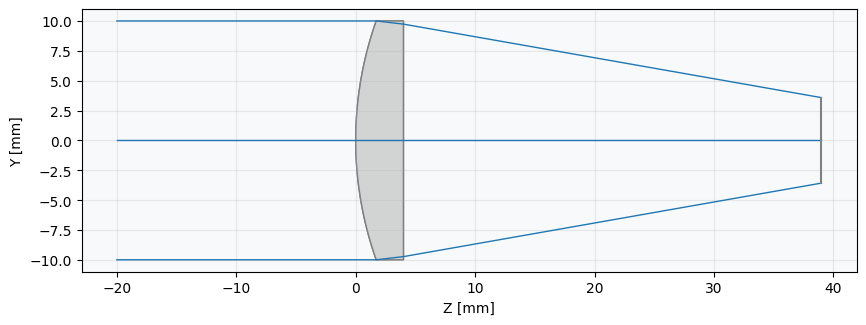

In [4]:
lens = Lens()
lens.draw()

In [5]:
# define the rays to be traced
x_coords = torch.linspace(-10.0, 10.0, 9)
y_coords = torch.linspace(-10.0, 10.0, 9)

X, Y = torch.meshgrid(x_coords, y_coords, indexing="xy")

x_in = X.reshape(-1)
y_in = Y.reshape(-1)
z_in = be.zeros_like(x_in)
L_in = be.zeros_like(x_in)
M_in = be.zeros_like(x_in)
N_in = be.ones_like(x_in)
intensity = be.ones_like(x_in)

rays_in = RealRays(
    x=x_in,
    y=y_in,
    z=z_in,
    L=L_in,
    M=M_in,
    N=N_in,
    wavelength=0.550,
    intensity=intensity,
)

In [22]:
# create the combinations (R1, R2)
r1 = torch.linspace(20.0, 100.0, 64, requires_grad=True)
r2 = torch.linspace(-100, -20.0, 64, requires_grad=True)
R1, R2 = torch.meshgrid(r1, r2, indexing="xy")

# flatten the arrays
R1 = R1.reshape(-1)
R2 = R2.reshape(-1)
print(R1[0])
print(R1[0].item())
print(R1[0].requires_grad)

tensor(20., grad_fn=<SelectBackward0>)
20.0
True


In [ ]:
rms_list = []
drms_dr1_list = []
drms_dr2_list = []

# main design loop
for i in range(len(R1)):
    current_r1_param = R1[i]
    current_r2_param = R2[i]

    lens.set_radius(current_r1_param, 1)
    lens.set_radius(current_r2_param, 2)

    sd = SpotDiagram(lens, num_rings=6, distribution="hexapolar")
    rms_tensor_output = sd.rms_spot_radius()[0][0]

    rms_list.append(rms_tensor_output.item())

    grads = torch.autograd.grad(
        outputs=rms_tensor_output,
        inputs=[current_r1_param, current_r2_param],
        retain_graph=True,
        allow_unused=False,
    )

    drms_dr1_list.append(grads[0].item())
    drms_dr2_list.append(grads[1].item())

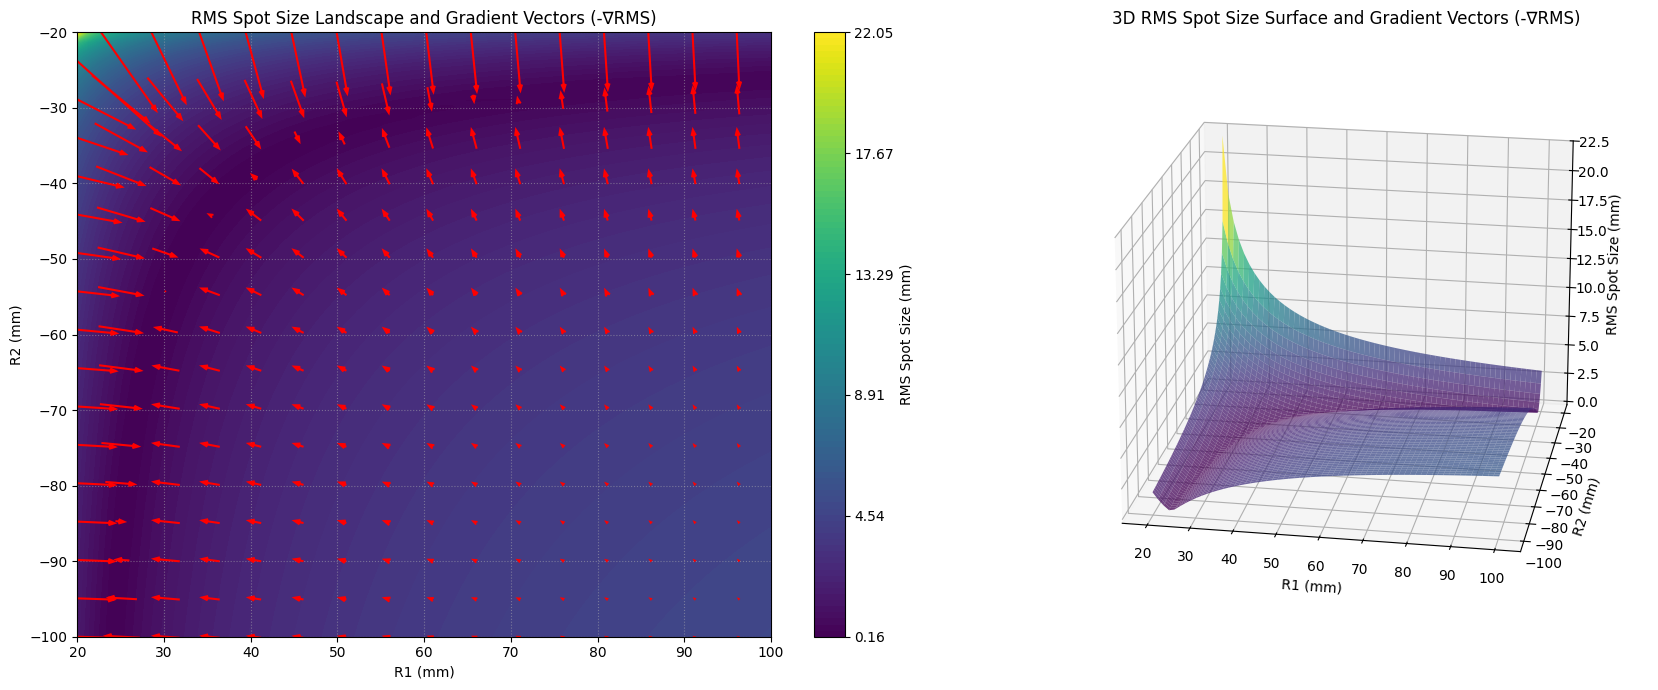

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting


# data preparation for contour and 3D surface plots

R1_mesh_np = R1.reshape(64, 64).detach().numpy()
R2_mesh_np = R2.reshape(64, 64).detach().numpy()
rms_values_grid_np = torch.tensor(rms_list).reshape(64, 64).detach().numpy()
dRMS_dR1_grid_np = torch.tensor(drms_dr1_list).reshape(64, 64).detach().numpy()
dRMS_dR2_grid_np = torch.tensor(drms_dr2_list).reshape(64, 64).detach().numpy()


fig = plt.figure(figsize=(18, 7))

# --- First subplot: Contour plot with arrows ---
ax1 = fig.add_subplot(1, 2, 1)


min_rms = np.min(rms_values_grid_np)
max_rms = np.max(rms_values_grid_np)
contour_levels_array = np.linspace(min_rms, max_rms, 100)

contour_plot = ax1.contourf(
    R1_mesh_np,
    R2_mesh_np,
    rms_values_grid_np,
    levels=contour_levels_array,
    cmap="viridis",
    zorder=1,
)
cbar = plt.colorbar(contour_plot, ax=ax1, label="RMS Spot Size (mm)")
cbar.set_ticks(np.linspace(min_rms, max_rms, 6))
cbar.set_ticklabels([f"{val:.2f}" for val in np.linspace(min_rms, max_rms, 6)])


skip = (slice(None, None, 4), slice(None, None, 4))  # Plot every 4th point

# Plotting negative gradient to show direction of descent (minimization)
quiver_plot_2d = ax1.quiver(
    R1_mesh_np[skip],
    R2_mesh_np[skip],
    -dRMS_dR1_grid_np[skip],
    -dRMS_dR2_grid_np[skip],
    color="red",
    angles="xy",
    scale_units="xy",
    scale=None,
    pivot="middle",
    width=0.003,
    headwidth=3,
    headlength=4,
    zorder=2,
)

ax1.set_xlabel("R1 (mm)")
ax1.set_ylabel("R2 (mm)")
ax1.set_title("RMS Spot Size Landscape and Gradient Vectors (-∇RMS)")
ax1.grid(True, linestyle=":", alpha=0.5)


# --- Second subplot: 3D Surface plot ---
ax2 = fig.add_subplot(1, 2, 2, projection="3d")


surface_plot = ax2.plot_surface(
    R1_mesh_np,
    R2_mesh_np,
    rms_values_grid_np,
    cmap="viridis",
    edgecolor="none",
    alpha=0.75,
    rcount=64,
    ccount=64,
    zorder=1,
)


ax2.set_xlabel("R1 (mm)")
ax2.set_ylabel("R2 (mm)")
ax2.set_zlabel("RMS Spot Size (mm)")
ax2.set_title("3D RMS Spot Size Surface and Gradient Vectors (-∇RMS)")
ax2.view_init(elev=20, azim=-80)  # Adjust view angle if needed

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()